In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from pydataset import data

import acquire
import prepare
from env import host, user, password 

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import graphviz
from graphviz import Graph

### Using titanic data, do the following:

In [2]:
#grab acquired dataset
df = acquire.get_titanic_data()
df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,None,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,None,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,None,Southampton,1


In [3]:
#grab cleaned df
df = prepare.clean_titanic(df)
df.head()

,passenger_id,survived,pclass,sibsp,parch,fare,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
0,0,0,3,1,0,7.2500,0,1,0,1
1,1,1,1,1,0,71.2833,0,0,0,0
2,2,1,3,0,0,7.9250,1,0,0,1
3,3,1,1,1,0,53.1000,0,0,0,1
4,4,0,3,0,0,8.0500,1,1,0,1


In [4]:
#split the data
train, test = train_test_split(df, test_size=.2, random_state=123, stratify=df.survived)
train, validate = train_test_split(train, test_size=.3, random_state=123, stratify=train.survived)


In [5]:
print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

#work w/ training data
train.head()

train -> (498, 10)
validate -> (214, 10)
test -> (179, 10)


,passenger_id,survived,pclass,sibsp,parch,fare,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
583,583,0,1,0,0,40.1250,1,1,0,0
165,165,1,3,0,2,20.5250,0,1,0,1
50,50,0,3,4,1,39.6875,0,1,0,1
259,259,1,2,0,1,26.0000,0,0,0,1
306,306,1,1,0,0,110.8833,1,0,0,0


In [6]:
# Setup our X inputs and y target variable for each split
X_train = train.drop(columns=['survived'])
y_train = train.survived

X_validate = validate.drop(columns=['survived'])
y_validate = validate.survived

X_test = test.drop(columns=['survived'])
y_test = test.survived

# Decision Tree Exercises

### 1. What is your baseline prediction? What is your baseline accuracy? *remember: your baseline prediction for a classification problem is predicting the most prevelant class in the training dataset (the mode). When you make those predictions, what is your accuracy? This is your baseline accuracy.*

In [7]:
#baseline prediction:
#predicting the most prevalant class in training dataset(the mode)
train.survived.value_counts()

0    307
1    191
Name: survived, dtype: int64

In [8]:
#baseline model would be to predict 0 since it is most prevalant
train["baseline_prediction"] = train.survived.value_counts().idxmax()
train.head()

#or train['baseline_prediction'] = 0

,passenger_id,survived,pclass,sibsp,parch,fare,alone,sex_male,embark_town_Queenstown,embark_town_Southampton,baseline_prediction
583,583,0,1,0,0,40.1250,1,1,0,0,0
165,165,1,3,0,2,20.5250,0,1,0,1,0
50,50,0,3,4,1,39.6875,0,1,0,1,0
259,259,1,2,0,1,26.0000,0,0,0,1,0
306,306,1,1,0,0,110.8833,1,0,0,0,0


In [9]:
#baseline accuracy:
#when making baseline predictions, what is the accuracy?
baseline_accuracy = (train.survived == train.baseline_prediction).mean()

print(f'baseline accuracy: {baseline_accuracy:.2%}')

baseline accuracy: 61.65%


### 2. Fit the decision tree classifier to your training sample and transform (i.e. make predictions on the training sample)

In [10]:
#create/generate a blank, new Decision Tree model/object **with max_depth argument**
clf1 = DecisionTreeClassifier(max_depth=3, random_state=123)

In [11]:
#fit/train the model(decision tree classifier) to training data/sample
# format: model.fit(X, y)

clf1 = clf1.fit(X_train, y_train)
clf1.classes_

array([0, 1])

In [12]:
#visualize
dot_data = export_graphviz(clf1, feature_names= X_train.columns, rounded=True, filled=True, out_file=None, class_names=['Did not survive', 'Survived'])
graph = graphviz.Source(dot_data) 

graph.render('titanic_decision_tree', view=True)

'titanic_decision_tree.pdf'

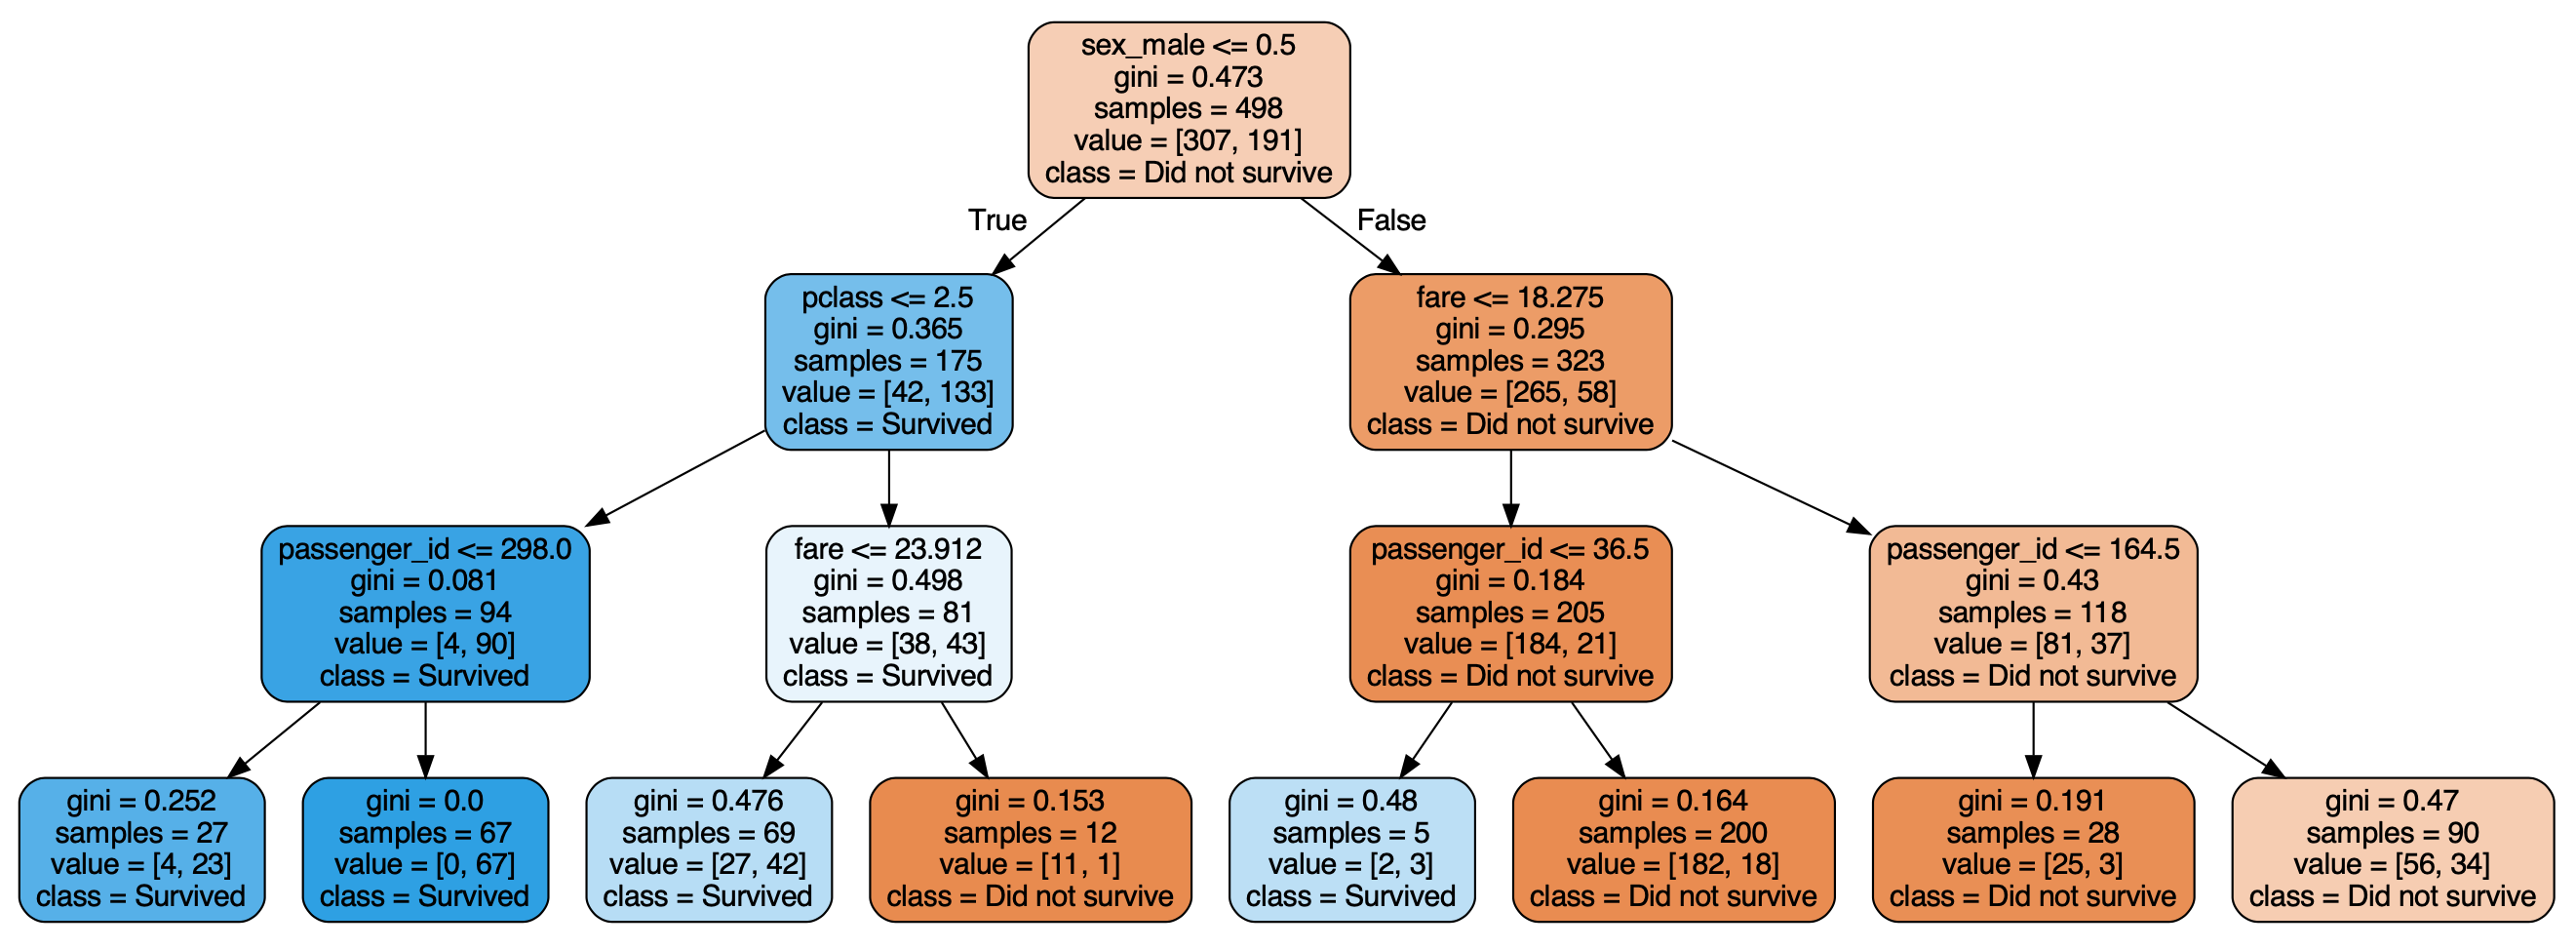

In [13]:
#transform/make predictions using trained model (the training sample)
y_pred = clf1.predict(X_train)
y_pred[0:5]

array([0, 0, 0, 1, 1])

In [14]:
# Estimate the probabilities for each class
# aka get prediction probabilites for each class for each observation in train
y_pred_proba = clf1.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.62222222, 0.37777778],
       [0.62222222, 0.37777778],
       [0.89285714, 0.10714286],
       [0.14814815, 0.85185185],
       [0.        , 1.        ]])

### 3. Evaluate your in-sample results using the model score, confusion matrix, and classification report.



#### Model 1

In [15]:
# Let's evaluate the model 
print('Accuracy of Decision Tree classifier on training set with max depth of 3: {:.2f}'
      .format(clf1.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set with max depth of 3: 0.82


In [16]:
# confusion matrix
conf = confusion_matrix(y_train, y_pred)
conf

array([[274,  33],
       [ 56, 135]])

In [17]:
y_train.value_counts()

0    307
1    191
Name: survived, dtype: int64

In [18]:
labels = sorted(y_train.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,0,1
0,274,33
1,56,135


In [19]:
# turn confusion matrix into a dataframe for human legibility
conf_df = pd.DataFrame(conf, 
                       columns=['predict_death', 'predict_survive'], 
                       index=['actual_death', 'actual_survive'])
conf_df

,predict_death,predict_survive
actual_death,274,33
actual_survive,56,135


In [20]:
# make a key for reference
rubric_df = pd.DataFrame([['true negative', 'false positive'],['false negative', 'true positive']], 
                         columns=['predict_death', 'predict_survive'], 
                         index=['actual_death', 'actual_survive'])
rubric_df

,predict_death,predict_survive
actual_death,true negative,false positive
actual_survive,false negative,true positive


In [21]:
#classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       307
           1       0.80      0.71      0.75       191

    accuracy                           0.82       498
   macro avg       0.82      0.80      0.81       498
weighted avg       0.82      0.82      0.82       498



In [22]:
#cleaner way to read classification report
class_report = classification_report(y_train, y_pred, output_dict=True)
pd.DataFrame(class_report).T

,precision,recall,f1-score,support
0,0.830303,0.892508,0.860283,307.000000
1,0.803571,0.706806,0.752089,191.000000
accuracy,0.821285,0.821285,0.821285,0.821285
macro avg,0.816937,0.799657,0.806186,498.000000
weighted avg,0.820051,0.821285,0.818787,498.000000


In [23]:
#rename classes
pd.DataFrame(class_report).rename(columns={'0': 'deceased', '1': 'survived'}).T

,precision,recall,f1-score,support
deceased,0.830303,0.892508,0.860283,307.000000
survived,0.803571,0.706806,0.752089,191.000000
accuracy,0.821285,0.821285,0.821285,0.821285
macro avg,0.816937,0.799657,0.806186,498.000000
weighted avg,0.820051,0.821285,0.818787,498.000000


### 4. Compute: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.



In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support 

In [25]:
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()

In [26]:
#accuracy (tp+tn/tp+tn+fp+fn)
accuracy_score(y_train, y_pred)

0.821285140562249

In [27]:
#true positive rate (sensitivity aka recall) (tp/tp+fn)
tp / (tp + fn)

0.7068062827225131

In [28]:
#false positive rate (fp/fp+tn)
fp / (fp + tn)

0.10749185667752444

In [29]:
#true negative rate (specificity) (tn/tn+fp)
tn / tn + fp

34.0

In [30]:
#false negative rate (miss rate)(fn/fn+tp)
fn / (fn + tn)

0.1696969696969697

In [31]:
#precision (positive predictive value) (tp/tp+fp)
precision_score(y_train, y_pred)

0.8035714285714286

In [32]:
#recall (aka sensitivity) (tp/tp+fn)
recall_score(y_train, y_pred)

0.7068062827225131

In [33]:
#f1-score (2*precision*recall / precision + recall)
f1_score(y_train, y_pred)

0.7520891364902508

In [34]:
#support (number of occurrences of each class in y_true)
precision_recall_fscore_support(y_train, y_pred)[-1]

array([307, 191])

In [35]:
#can create function to calculate these metrics
def get_metrics_binary(clf):
    '''
    get_metrics_binary takes in a confusion matrix (cnf) for a binary classifier and prints out metrics based on
    values in variables named X_train, y_train, and y_pred.
    
    return: a classification report as a transposed DataFrame
    '''
    accuracy = clf.score(X_train, y_train)
    class_report = pd.DataFrame(classification_report(y_train, y_pred, output_dict=True)).T
    conf = confusion_matrix(y_train, y_pred)
    tpr = conf[1][1] / conf[1].sum()
    fpr = conf[0][1] / conf[0].sum()
    tnr = conf[0][0] / conf[0].sum()
    fnr = conf[1][0] / conf[1].sum()
    print(f'''
    The accuracy for our model is {accuracy:.4}
    The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
    The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
    ''')
    return class_report

In [36]:
#call function
report_df = get_metrics_binary(clf1)

report_df


    The accuracy for our model is 0.8213
    The True Positive Rate is 0.707, The False Positive Rate is 0.107,
    The True Negative Rate is 0.893, and the False Negative Rate is 0.293
    


,precision,recall,f1-score,support
0,0.830303,0.892508,0.860283,307.000000
1,0.803571,0.706806,0.752089,191.000000
accuracy,0.821285,0.821285,0.821285,0.821285
macro avg,0.816937,0.799657,0.806186,498.000000
weighted avg,0.820051,0.821285,0.818787,498.000000


### 5. Run through steps 2-4 using a different `max_depth` value.



#### Model 2

In [37]:
#create new blank decision tree w/ new max_depth value
clf2 = DecisionTreeClassifier(max_depth=4, random_state=123)

In [38]:
#fit/train the model(decision tree classifier) to training data/sample
# format: model.fit(X, y)

clf2 = clf2.fit(X_train, y_train)
clf2.classes_

array([0, 1])

In [39]:
#visualize
dot_data = export_graphviz(clf2, feature_names= X_train.columns, rounded=True, filled=True, out_file=None, class_names=['Did not survive', 'Survived'])
graph = graphviz.Source(dot_data) 

graph.render('titanic_decision_tree', view=True, format="pdf")

'titanic_decision_tree.pdf'

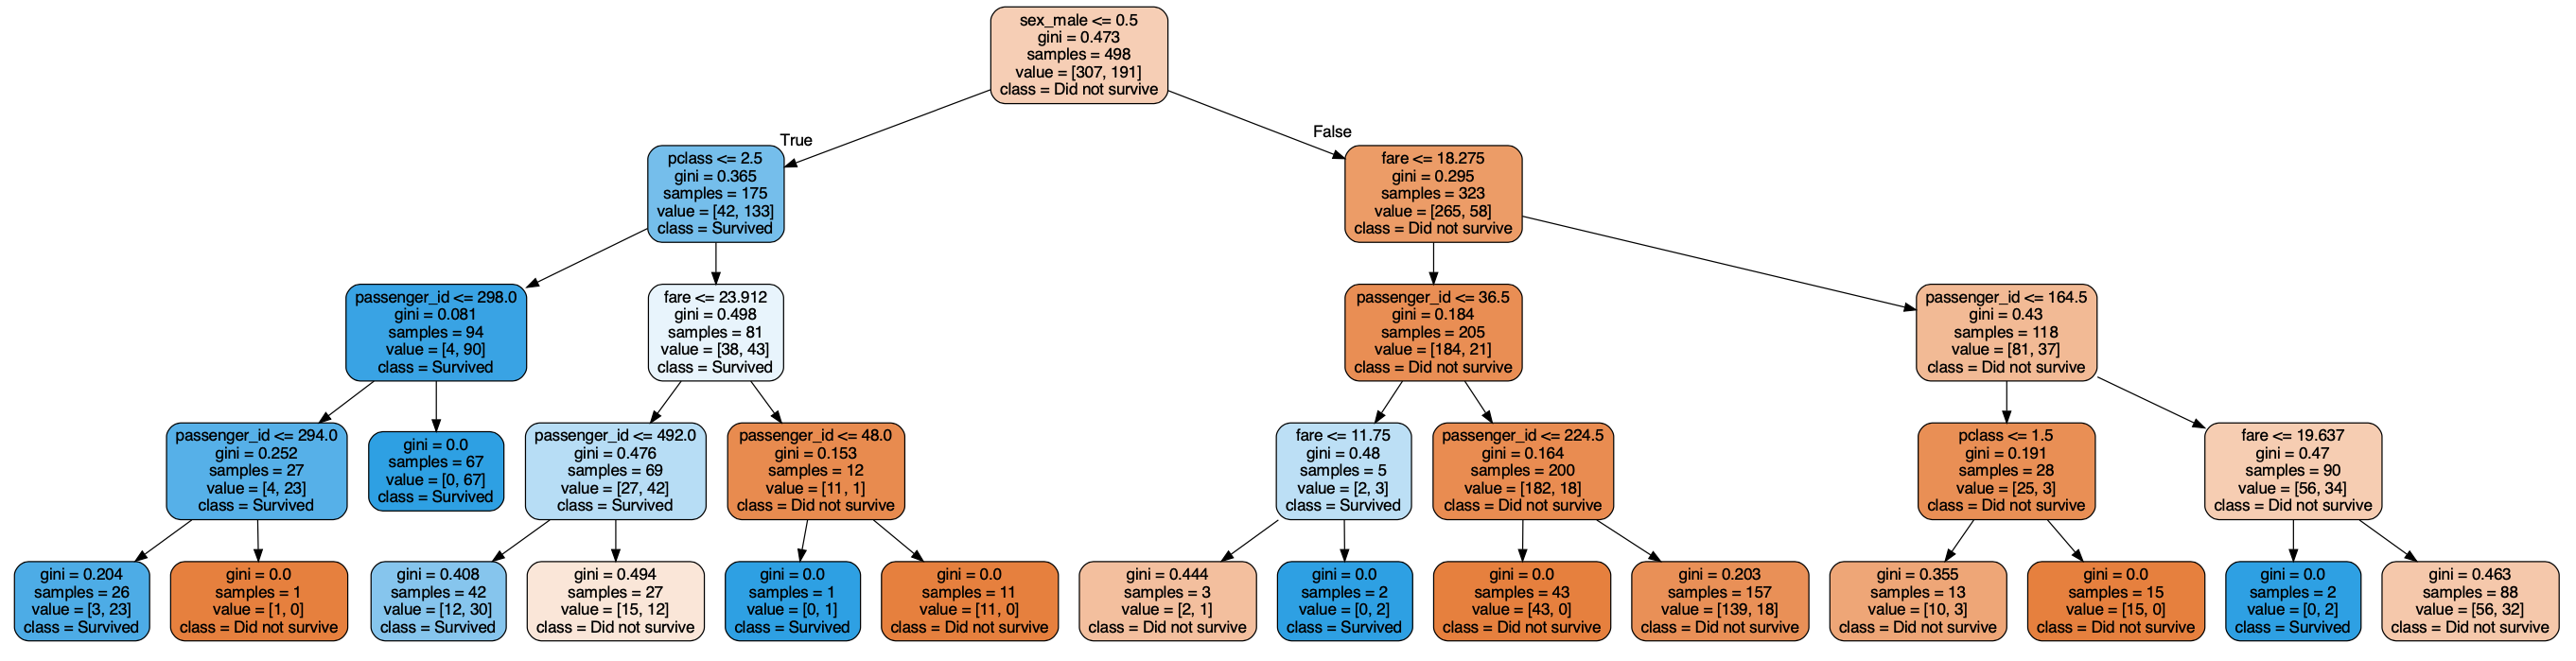

In [40]:
#transform/make predictions using trained model (the training sample)
y_pred = clf2.predict(X_train)
y_pred[0:5]

array([0, 0, 0, 1, 1])

In [41]:
# Estimate the probabilities for each class
# aka get prediction probabilites for each class for each observation in train
y_pred_proba = clf2.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.63636364, 0.36363636],
       [0.63636364, 0.36363636],
       [1.        , 0.        ],
       [0.11538462, 0.88461538],
       [0.        , 1.        ]])

In [42]:
# Let's evaluate the model
print('Accuracy of Decision Tree classifier on training set with max depth of 4: {:.2f}'
      .format(clf2.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set with max depth of 4: 0.84


In [43]:
# confusion matrix

confusion_matrix(y_train, y_pred)

array([[292,  15],
       [ 66, 125]])

In [44]:
#classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       307
           1       0.89      0.65      0.76       191

    accuracy                           0.84       498
   macro avg       0.85      0.80      0.82       498
weighted avg       0.85      0.84      0.83       498



In [45]:
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()

#accuracy
accuracy = accuracy_score(y_train, y_pred)

#true positive rate
tpr = tp / (tp + fn)

#false positive rate 
fpr = fp / (fp + tn)

#true negative rate (specificity)
tnr = tn / tn + fp

#false negative rate (miss rate)
fnr = fn / (fn + tn)

#precision (positive predictive value)
precision = precision_score(y_train, y_pred)

#recall (sensitivity)
recall = recall_score(y_train, y_pred)

#f1-score
f1 = f1_score(y_train, y_pred)

#support (number of occurrences of each class in y_true)
support = precision_recall_fscore_support(y_train, y_pred)[-1]


print(f'''
Accuracy: {accuracy}
true positive rate: {tpr}
false positive rate: {fpr}
true negative rate: {tnr}
false negative rate:{fnr}
precision: {precision}
recall: {recall}
f1-score: {f1}
support: {support}
''')


Accuracy: 0.8373493975903614
true positive rate: 0.6544502617801047
false positive rate: 0.048859934853420196
true negative rate: 16.0
false negative rate:0.18435754189944134
precision: 0.8928571428571429
recall: 0.6544502617801047
f1-score: 0.7552870090634441
support: [307 191]



### 6. Which model performs better on your in-sample data?

- model 2 is more accurate

In [46]:
print(f'baseline accuracy: {baseline_accuracy:.2%}')
print('clf1 accuracy: 82.13%')
print('clf2 accuracy: 83.73%')

baseline accuracy: 61.65%
clf1 accuracy: 82.13%
clf2 accuracy: 83.73%


### 7. Which model performs best on your out-of-sample data, the `validate` set?

- model 1 performed better

In [47]:
print(f'baseline accuracy: {baseline_accuracy:.2%}')
print('Accuracy of Decision Tree classifier on validate set model 1: {:.2f}'
     .format(clf1.score(X_validate, y_validate)))
print('Accuracy of Decision Tree classifier on validate set model 2: {:.2f}'
     .format(clf2.score(X_validate, y_validate)))

baseline accuracy: 61.65%
Accuracy of Decision Tree classifier on validate set model 1: 0.78
Accuracy of Decision Tree classifier on validate set model 2: 0.76


In [48]:
# Let's evaluate model 1 on out-of-sample data
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf1.score(X_validate, y_validate)))

Accuracy of Decision Tree classifier on validate set: 0.78


In [49]:
# Use the classification model trained on train data to make predictions on validate data
y_pred = clf1.predict(X_validate)
y_pred[0:3]

array([0, 0, 0])

In [50]:
y_validate.head(3)


610    0
424    0
568    0
Name: survived, dtype: int64

In [51]:
# Compare actual y values from validate to predictions based on X_validate
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.86      0.83       132
           1       0.74      0.63      0.68        82

    accuracy                           0.78       214
   macro avg       0.77      0.75      0.76       214
weighted avg       0.77      0.78      0.77       214



In [52]:
# Let's evaluate model 2 on out-of-sample data
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf2.score(X_validate, y_validate)))

Accuracy of Decision Tree classifier on validate set: 0.76


In [53]:
# Use the classification model trained on train data to make predictions on validate data
y_pred = clf2.predict(X_validate)
y_pred[0:3]

array([0, 0, 0])

In [54]:
y_validate.head(3)


610    0
424    0
568    0
Name: survived, dtype: int64

In [55]:
# Compare actual y values from validate to predictions based on X_validate
print(classification_report(y_validate, y_pred))


              precision    recall  f1-score   support

           0       0.77      0.88      0.82       132
           1       0.75      0.57      0.65        82

    accuracy                           0.76       214
   macro avg       0.76      0.73      0.73       214
weighted avg       0.76      0.76      0.75       214



# Random Forest Exercises

### 1. Fit the Random Forest classifier to your training sample and transform (i.e. make predictions on the training sample) setting the random_state accordingly and setting min_samples_leaf = 1 and max_depth = 10.

In [56]:
from sklearn.ensemble import RandomForestClassifier

#### Model 1:

In [57]:
#create blank Random Forest classifier
rf1 = RandomForestClassifier(max_depth=10, min_samples_leaf=1, random_state=123)
rf1

RandomForestClassifier(max_depth=10, random_state=123)

In [58]:
#fit/train the model(random tree classifier) to training data/sample
# format: model.fit(X, y)

rf1 = rf1.fit(X_train, y_train)
rf1.classes_

array([0, 1])

In [59]:
#transform/make predictions using trained model (the training sample)
y_pred = rf1.predict(X_train)
y_pred[0:5]

array([0, 1, 0, 1, 1])

In [60]:
# Estimate the probabilities for each class
# aka get prediction probabilites for each class for each observation in train
y_pred_proba = rf1.predict_proba(X_train)
y_pred_proba[0:5]

array([[8.52316668e-01, 1.47683332e-01],
       [3.02120370e-01, 6.97879630e-01],
       [9.70000000e-01, 3.00000000e-02],
       [3.79894180e-03, 9.96201058e-01],
       [4.16666667e-04, 9.99583333e-01]])

In [61]:
print(rf1.feature_importances_)

[0.23476456 0.09026042 0.0515695  0.03433068 0.22753076 0.02154907
 0.30308632 0.0110124  0.0258963 ]


### 2. Evaluate your results using the model score, confusion matrix, and classification report.

In [62]:
# Evaluate the rf model 1
print('Accuracy of 1st Random Forest classifier on training set with max depth of 10 and 1 min sample leaf: {:.2f}'
      .format(rf1.score(X_train, y_train)))

Accuracy of 1st Random Forest classifier on training set with max depth of 10 and 1 min sample leaf: 0.97


In [63]:
# confusion matrix
conf = confusion_matrix(y_train, y_pred)
conf

array([[307,   0],
       [ 14, 177]])

In [64]:
labels = sorted(y_train.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,0,1
0,307,0
1,14,177


In [65]:
# turn confusion matrix into a dataframe for human legibility
conf_df = pd.DataFrame(conf, 
                       columns=['predict_death', 'predict_survive'], 
                       index=['actual_death', 'actual_survive'])
conf_df

,predict_death,predict_survive
actual_death,307,0
actual_survive,14,177


In [66]:
# make a key for reference
rubric_df = pd.DataFrame([['true negative', 'false positive'],['false negative', 'true positive']], 
                         columns=['predict_death', 'predict_survive'], 
                         index=['actual_death', 'actual_survive'])
rubric_df

,predict_death,predict_survive
actual_death,true negative,false positive
actual_survive,false negative,true positive


In [67]:
#classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       307
           1       1.00      0.93      0.96       191

    accuracy                           0.97       498
   macro avg       0.98      0.96      0.97       498
weighted avg       0.97      0.97      0.97       498



In [68]:
#cleaner way to read classification report w/ renamed classes
class_report = classification_report(y_train, y_pred, output_dict=True)

pd.DataFrame(class_report).rename(columns={'0': 'deceased', '1': 'survived'}).T

,precision,recall,f1-score,support
deceased,0.956386,1.000000,0.977707,307.000000
survived,1.000000,0.926702,0.961957,191.000000
accuracy,0.971888,0.971888,0.971888,0.971888
macro avg,0.978193,0.963351,0.969832,498.000000
weighted avg,0.973114,0.971888,0.971666,498.000000


### 3. Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [69]:
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()

#accuracy
accuracy1 = accuracy_score(y_train, y_pred)

#true positive rate
tpr1 = tp / (tp + fn)

#false positive rate 
fpr1 = fp / (fp + tn)

#true negative rate (specificity)
tnr1 = tn / tn + fp

#false negative rate (miss rate)
fnr1 = fn / (fn + tn)

#precision (positive predictive value)
precision1 = precision_score(y_train, y_pred)

#recall (sensitivity)
recall1 = recall_score(y_train, y_pred)

#f1-score
f11 = f1_score(y_train, y_pred)

#support (number of occurrences of each class in y_true)
support1 = precision_recall_fscore_support(y_train, y_pred)[-1]


print(f'''
Model 1:
Accuracy: {accuracy1}
true positive rate: {tpr1}
false positive rate: {fpr1}
true negative rate: {tnr1}
false negative rate:{fnr1}
precision: {precision1}
recall: {recall1}
f1-score: {f11}
support: {support1}
''')


Model 1:
Accuracy: 0.9718875502008032
true positive rate: 0.9267015706806283
false positive rate: 0.0
true negative rate: 1.0
false negative rate:0.04361370716510903
precision: 1.0
recall: 0.9267015706806283
f1-score: 0.9619565217391305
support: [307 191]



### 4. Run through steps increasing your min_samples_leaf and decreasing your max_depth.



#### Model 2

In [70]:
#create 2nd blank Random Forest classifier
rf2 = RandomForestClassifier(max_depth=8, min_samples_leaf=3, random_state=123)
rf2

RandomForestClassifier(max_depth=8, min_samples_leaf=3, random_state=123)

In [71]:
#fit/train the model(random tree classifier) to training data/sample
# format: model.fit(X, y)

rf2 = rf2.fit(X_train, y_train)
rf2.classes_

array([0, 1])

In [72]:
#transform/make predictions using trained model (the training sample)
y_pred = rf2.predict(X_train)
y_pred[0:5]

array([0, 0, 0, 1, 1])

In [73]:
# Estimate the probabilities for each class
# aka get prediction probabilites for each class for each observation in train
y_pred_proba = rf2.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.70224372, 0.29775628],
       [0.60054726, 0.39945274],
       [0.92136111, 0.07863889],
       [0.03732751, 0.96267249],
       [0.02770117, 0.97229883]])

In [74]:
print(rf2.feature_importances_)

[0.15666828 0.11414457 0.04712091 0.0246642  0.18618595 0.02031131
 0.41601814 0.01178589 0.02310073]


In [75]:
# Evaluate the rf model 2
print('Accuracy of 2nd Random Forest classifier on training set with max depth of 8 and 3 min sample leaves: {:.2f}'
      .format(rf2.score(X_train, y_train)))

Accuracy of 2nd Random Forest classifier on training set with max depth of 8 and 3 min sample leaves: 0.90


In [76]:
# confusion matrix
conf = confusion_matrix(y_train, y_pred)
conf

array([[299,   8],
       [ 44, 147]])

In [77]:
labels = sorted(y_train.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,0,1
0,299,8
1,44,147


In [78]:
# turn confusion matrix into a dataframe
conf_df = pd.DataFrame(conf, 
                       columns=['predict_death', 'predict_survive'], 
                       index=['actual_death', 'actual_survive'])
conf_df

,predict_death,predict_survive
actual_death,299,8
actual_survive,44,147


In [79]:
# make a key for reference
rubric_df = pd.DataFrame([['true negative', 'false positive'],['false negative', 'true positive']], 
                         columns=['predict_death', 'predict_survive'], 
                         index=['actual_death', 'actual_survive'])
rubric_df

,predict_death,predict_survive
actual_death,true negative,false positive
actual_survive,false negative,true positive


In [80]:
#classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       307
           1       0.95      0.77      0.85       191

    accuracy                           0.90       498
   macro avg       0.91      0.87      0.88       498
weighted avg       0.90      0.90      0.89       498



In [81]:
#cleaner way to read classification report w/ renamed classes
class_report = classification_report(y_train, y_pred, output_dict=True)

pd.DataFrame(class_report).rename(columns={'0': 'deceased', '1': 'survived'}).T

,precision,recall,f1-score,support
deceased,0.871720,0.973941,0.920000,307.000000
survived,0.948387,0.769634,0.849711,191.000000
accuracy,0.895582,0.895582,0.895582,0.895582
macro avg,0.910054,0.871787,0.884855,498.000000
weighted avg,0.901125,0.895582,0.893042,498.000000


In [82]:
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()

#accuracy
accuracy2 = accuracy_score(y_train, y_pred)

#true positive rate
tpr2 = tp / (tp + fn)

#false positive rate 
fpr2 = fp / (fp + tn)

#true negative rate (specificity)
tnr2 = tn / tn + fp

#false negative rate (miss rate)
fnr2 = fn / (fn + tn)

#precision (positive predictive value)
precision2 = precision_score(y_train, y_pred)

#recall (sensitivity)
recall2 = recall_score(y_train, y_pred)

#f1-score
f12 = f1_score(y_train, y_pred)

#support (number of occurrences of each class in y_true)
support2 = precision_recall_fscore_support(y_train, y_pred)[-1]


print(f'''
Model 2:
Accuracy: {accuracy2}
true positive rate: {tpr2}
false positive rate: {fpr2}
true negative rate: {tnr2}
false negative rate:{fnr2}
precision: {precision2}
recall: {recall2}
f1-score: {f12}
support: {support2}
''')


Model 2:
Accuracy: 0.8955823293172691
true positive rate: 0.7696335078534031
false positive rate: 0.026058631921824105
true negative rate: 9.0
false negative rate:0.1282798833819242
precision: 0.9483870967741935
recall: 0.7696335078534031
f1-score: 0.8497109826589596
support: [307 191]



#### Model 3

In [83]:
#create 3rd blank Random Forest classifier
rf3 = RandomForestClassifier(max_depth=5, min_samples_leaf=7, random_state=123)
rf3

RandomForestClassifier(max_depth=5, min_samples_leaf=7, random_state=123)

In [84]:
#fit/train the model(random tree classifier) to training data/sample
# format: model.fit(X, y)

rf3 = rf3.fit(X_train, y_train)
rf3.classes_

array([0, 1])

In [85]:
#transform/make predictions using trained model (the training sample)
y_pred = rf3.predict(X_train)
y_pred[0:5]

array([0, 0, 0, 1, 1])

In [86]:
# Estimate the probabilities for each class
# aka get prediction probabilites for each class for each observation in train
y_pred_proba = rf3.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.64525716, 0.35474284],
       [0.69186847, 0.30813153],
       [0.91195197, 0.08804803],
       [0.1175142 , 0.8824858 ],
       [0.06352455, 0.93647545]])

In [87]:
print(rf3.feature_importances_)

[0.09166597 0.1341021  0.03944417 0.01761992 0.14594578 0.02377049
 0.52101339 0.0105988  0.01583938]


In [88]:
# Evaluate the rf model 3
print('Accuracy of 3rd Random Forest classifier on training set with max depth of 5 and 7 min sample leaves: {:.2f}'
      .format(rf2.score(X_train, y_train)))

Accuracy of 3rd Random Forest classifier on training set with max depth of 5 and 7 min sample leaves: 0.90


In [89]:
# confusion matrix
conf = confusion_matrix(y_train, y_pred)
conf

array([[291,  16],
       [ 64, 127]])

In [90]:
labels = sorted(y_train.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,0,1
0,291,16
1,64,127


In [91]:
#confusion matrix into a dataframe
conf_df = pd.DataFrame(conf, 
                       columns=['predict_death', 'predict_survive'], 
                       index=['actual_death', 'actual_survive'])
conf_df

,predict_death,predict_survive
actual_death,291,16
actual_survive,64,127


In [92]:
#cleaner way to read classification report w/ renamed classes
class_report = classification_report(y_train, y_pred, output_dict=True)

pd.DataFrame(class_report).rename(columns={'0': 'deceased', '1': 'survived'}).T

,precision,recall,f1-score,support
deceased,0.819718,0.947883,0.879154,307.000000
survived,0.888112,0.664921,0.760479,191.000000
accuracy,0.839357,0.839357,0.839357,0.839357
macro avg,0.853915,0.806402,0.819817,498.000000
weighted avg,0.845950,0.839357,0.833638,498.000000


In [93]:
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()

#accuracy
accuracy3 = accuracy_score(y_train, y_pred)

#true positive rate
tpr3 = tp / (tp + fn)

#false positive rate 
fpr3 = fp / (fp + tn)

#true negative rate (specificity)
tnr3 = tn / tn + fp

#false negative rate (miss rate)
fnr3 = fn / (fn + tn)

#precision (positive predictive value)
precision3 = precision_score(y_train, y_pred)

#recall (sensitivity)
recall3 = recall_score(y_train, y_pred)

#f1-score
f13 = f1_score(y_train, y_pred)

#support (number of occurrences of each class in y_true)
support3 = precision_recall_fscore_support(y_train, y_pred)[-1]


print(f'''
Model 3:
Accuracy: {accuracy3}
true positive rate: {tpr3}
false positive rate: {fpr3}
true negative rate: {tnr3}
false negative rate:{fnr3}
precision: {precision3}
recall: {recall3}
f1-score: {f13}
support: {support3}
''')


Model 3:
Accuracy: 0.8393574297188755
true positive rate: 0.6649214659685864
false positive rate: 0.05211726384364821
true negative rate: 17.0
false negative rate:0.18028169014084508
precision: 0.8881118881118881
recall: 0.6649214659685864
f1-score: 0.7604790419161678
support: [307 191]



#### Model 4

In [94]:
#create 4th blank Random Forest classifier
rf4 = RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)
rf4

RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)

In [95]:
#fit/train the model(random tree classifier) to training data/sample
# format: model.fit(X, y)

rf4 = rf4.fit(X_train, y_train)
rf4.classes_

array([0, 1])

In [96]:
#transform/make predictions using trained model (the training sample)
y_pred = rf4.predict(X_train)
y_pred[0:5]

array([0, 0, 0, 1, 1])

In [97]:
# Estimate the probabilities for each class
# aka get prediction probabilites for each class for each observation in train
y_pred_proba = rf4.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.63471925, 0.36528075],
       [0.7175298 , 0.2824702 ],
       [0.80955637, 0.19044363],
       [0.18289449, 0.81710551],
       [0.12973526, 0.87026474]])

In [98]:
print(rf4.feature_importances_)

[0.0501479  0.14879703 0.03862614 0.01865504 0.14769532 0.02880955
 0.53988323 0.01565955 0.01172624]


In [99]:
# Evaluate the rf model 4
print('Accuracy of 4th Random Forest classifier on training set with max depth of 3 and 3 min sample leaves: {:.2f}'
      .format(rf4.score(X_train, y_train)))

Accuracy of 4th Random Forest classifier on training set with max depth of 3 and 3 min sample leaves: 0.83


In [100]:
# confusion matrix
conf = confusion_matrix(y_train, y_pred)
conf

array([[283,  24],
       [ 61, 130]])

In [101]:
labels = sorted(y_train.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,0,1
0,283,24
1,61,130


In [102]:
#confusion matrix into a dataframe
conf_df = pd.DataFrame(conf, 
                       columns=['predict_death', 'predict_survive'], 
                       index=['actual_death', 'actual_survive'])
conf_df

,predict_death,predict_survive
actual_death,283,24
actual_survive,61,130


In [103]:
#cleaner way to read classification report w/ renamed classes
class_report = classification_report(y_train, y_pred, output_dict=True)

pd.DataFrame(class_report).rename(columns={'0': 'deceased', '1': 'survived'}).T

,precision,recall,f1-score,support
deceased,0.822674,0.921824,0.869432,307.000000
survived,0.844156,0.680628,0.753623,191.000000
accuracy,0.829317,0.829317,0.829317,0.829317
macro avg,0.833415,0.801226,0.811527,498.000000
weighted avg,0.830913,0.829317,0.825015,498.000000


In [104]:
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()

#accuracy
accuracy4 = accuracy_score(y_train, y_pred)

#true positive rate
tpr4 = tp / (tp + fn)

#false positive rate 
fpr4 = fp / (fp + tn)

#true negative rate (specificity)
tnr4 = tn / tn + fp

#false negative rate (miss rate)
fnr4 = fn / (fn + tn)

#precision (positive predictive value)
precision4 = precision_score(y_train, y_pred)

#recall (sensitivity)
recall4 = recall_score(y_train, y_pred)

#f1-score
f14 = f1_score(y_train, y_pred)

#support (number of occurrences of each class in y_true)
support4 = precision_recall_fscore_support(y_train, y_pred)[-1]


print(f'''
Model 3:
Accuracy: {accuracy4}
true positive rate: {tpr4}
false positive rate: {fpr4}
true negative rate: {tnr4}
false negative rate:{fnr4}
precision: {precision4}
recall: {recall4}
f1-score: {f14}
support: {support4}
''')


Model 3:
Accuracy: 0.8293172690763052
true positive rate: 0.680628272251309
false positive rate: 0.0781758957654723
true negative rate: 25.0
false negative rate:0.17732558139534885
precision: 0.8441558441558441
recall: 0.680628272251309
f1-score: 0.753623188405797
support: [307 191]



### 5. What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?
- Model 1 performs the best
    - highest accuracy
    - same precision and recall as model 2
    - higher precision and recall than model 3
- Model 1 may be overfitted to the data
    - performs better in-sample because it is too specific for the data it is training for
- Model 1 max depth = 10 means more the splits it has and captures more information about the data
    - too much causes overfitting

In [105]:
print('Model 1')
print('-------')
print('max_depth=10, min_samples_leaf=1')
print(' ')
print('Accuracy on Train: {:.2f}' .format(rf1.score(X_train, y_train)))
print(f'Precision: {precision1:.2}')
print(f'Recall: {recall1:.2}')
print(' ')

print('\nModel 2')
print('-------')
print('max_depth=8, min_samples_leaf=3')
print(' ')
print('Accuracy on Train: {:.2f}' .format(rf2.score(X_train, y_train)))
print(f'Precision: {precision2:.2}')
print(f'Recall: {recall2:.2}')
print(' ')

print('\nModel 3')
print('-------')
print('max_depth=5, min_samples_leaf=7')
print(' ')
print('Accuracy on Train: {:.2f}'.format(rf3.score(X_train, y_train)))
print(f'Precision: {precision3:.2}')
print(f'Recall: {recall3: .2}')

print('\nModel 4')
print('-------')
print('max_depth=3, min_samples_leaf=3')
print(' ')
print('Accuracy on Train: {:.2f}'.format(rf4.score(X_train, y_train)))
print(f'Precision: {precision4:.2}')
print(f'Recall: {recall4: .2}')

Model 1
-------
max_depth=10, min_samples_leaf=1
 
Accuracy on Train: 0.97
Precision: 1.0
Recall: 0.93
 

Model 2
-------
max_depth=8, min_samples_leaf=3
 
Accuracy on Train: 0.90
Precision: 0.95
Recall: 0.77
 

Model 3
-------
max_depth=5, min_samples_leaf=7
 
Accuracy on Train: 0.84
Precision: 0.89
Recall:  0.66

Model 4
-------
max_depth=3, min_samples_leaf=3
 
Accuracy on Train: 0.83
Precision: 0.84
Recall:  0.68


### After making a few models, which one has the best performance (or closest metrics) on both train and validate?
- Model 1 was overfitted to the train data, did not show consistency from train to validate
- Model 3 was most consistent from train to validate
- Model 2 shows consistency from train to validate 
- Both Model 2 and 3 have overall lower scores than Model 1

In [106]:
print('Model 1')
print('-------')
print('Accuracy on validate set: {:.2f}'
     .format(rf1.score(X_validate, y_validate)))
print(' ')
print(' ')

print('Model 2')
print('-------')
print('Accuracy on validate set: {:.2f}'
     .format(rf2.score(X_validate, y_validate)))
print(' ')
print(' ')

print('Model 3')
print('-------')
print('Accuracy on validate set: {:.2f}'
     .format(rf3.score(X_validate, y_validate)))
print(' ')
print(' ')

print('Model 4')
print('-------')
print('Accuracy on validate set: {:.2f}'
     .format(rf4.score(X_validate, y_validate)))
print(' ')
print(' ')

Model 1
-------
Accuracy on validate set: 0.77
 
 
Model 2
-------
Accuracy on validate set: 0.79
 
 
Model 3
-------
Accuracy on validate set: 0.79
 
 
Model 4
-------
Accuracy on validate set: 0.79
 
 


# K-Nearest Neighbor (KNN) Exercises

### 1. Fit a K-Nearest Neighbors classifier to your training sample and transform (i.e. make predictions on the training sample)



In [107]:
from sklearn.neighbors import KNeighborsClassifier

#### Model 1

In [108]:
#create 1st blank knn classifier
knn1 = KNeighborsClassifier()
knn1

KNeighborsClassifier()

In [109]:
#fit/train the model
knn1.fit(X_train, y_train)

KNeighborsClassifier()

In [110]:
#fit/train the model(knn classifier) to training data/sample
# format: model.fit(X, y)

knn1 = knn1.fit(X_train, y_train)
knn1.classes_

array([0, 1])

In [111]:
#transform/make predictions using trained model (the training sample)
y_pred = knn1.predict(X_train)
y_pred[0:5]

array([1, 1, 0, 0, 1])

In [112]:
# Estimate the probabilities for each class
# aka get prediction probabilites for each class for each observation in train
y_pred_proba = knn1.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.4, 0.6],
       [0.4, 0.6],
       [0.6, 0.4],
       [0.6, 0.4],
       [0.2, 0.8]])

### 2. Evaluate your results using the model score, confusion matrix, and classification report.



In [113]:
# Evaluate the knn model 1
print('Accuracy of 1st KNN classifier on training set: {:.2f}'
      .format(knn1.score(X_train, y_train)))

Accuracy of 1st KNN classifier on training set: 0.74


In [114]:
# confusion matrix
conf = confusion_matrix(y_train, y_pred)
conf

array([[270,  37],
       [ 92,  99]])

In [115]:
labels = sorted(y_train.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,0,1
0,270,37
1,92,99


In [116]:
#confusion matrix into a dataframe
conf_df = pd.DataFrame(conf, 
                       columns=['predict_death', 'predict_survive'], 
                       index=['actual_death', 'actual_survive'])
conf_df

,predict_death,predict_survive
actual_death,270,37
actual_survive,92,99


In [117]:
#classification report w/ renamed classes
class_report = classification_report(y_train, y_pred, output_dict=True)

pd.DataFrame(class_report).rename(columns={'0': 'deceased', '1': 'survived'}).T

,precision,recall,f1-score,support
deceased,0.745856,0.879479,0.807175,307.000000
survived,0.727941,0.518325,0.605505,191.000000
accuracy,0.740964,0.740964,0.740964,0.740964
macro avg,0.736899,0.698902,0.706340,498.000000
weighted avg,0.738985,0.740964,0.729827,498.000000


### 3. Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.



In [118]:
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()

#accuracy
kaccuracy1 = accuracy_score(y_train, y_pred)

#true positive rate
ktpr1 = tp / (tp + fn)

#false positive rate 
kfpr1 = fp / (fp + tn)

#true negative rate (specificity)
ktnr1 = tn / tn + fp

#false negative rate (miss rate)
kfnr1 = fn / (fn + tn)

#precision (positive predictive value)
kprecision1 = precision_score(y_train, y_pred)

#recall (sensitivity)
krecall1 = recall_score(y_train, y_pred)

#f1-score
kf11 = f1_score(y_train, y_pred)

#support (number of occurrences of each class in y_true)
ksupport1 = precision_recall_fscore_support(y_train, y_pred)[-1]


print(f'''
KNN Model 1:
Accuracy: {kaccuracy1}
true positive rate: {ktpr1}
false positive rate: {kfpr1}
true negative rate: {ktnr1}
false negative rate:{kfnr1}
precision: {kprecision1}
recall: {krecall1}
f1-score: {kf11}
support: {ksupport1}
''')


KNN Model 1:
Accuracy: 0.7409638554216867
true positive rate: 0.518324607329843
false positive rate: 0.12052117263843648
true negative rate: 38.0
false negative rate:0.2541436464088398
precision: 0.7279411764705882
recall: 0.518324607329843
f1-score: 0.6055045871559633
support: [307 191]



### 4. Run through steps 2-4 setting k to 10



#### Model 2

In [119]:
#create 2nd blank knn classifier
knn2 = KNeighborsClassifier(n_neighbors=10)
knn2

KNeighborsClassifier(n_neighbors=10)

In [120]:
#fit/train the model
knn2.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [121]:
#fit/train the model(knn classifier) to training data/sample
# format: model.fit(X, y)

knn2 = knn2.fit(X_train, y_train)
knn2.classes_

array([0, 1])

In [122]:
#transform/make predictions using trained model (the training sample)
y_pred = knn2.predict(X_train)
y_pred[0:5]

array([0, 0, 0, 0, 1])

In [123]:
# Estimate the probabilities for each class
# aka get prediction probabilites for each class for each observation in train
y_pred_proba = knn2.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.6, 0.4],
       [0.7, 0.3],
       [0.7, 0.3],
       [0.5, 0.5],
       [0.4, 0.6]])

In [124]:
# Evaluate the knn model 2
print('Accuracy of 2nd KNN classifier on training set: {:.2f}'
      .format(knn2.score(X_train, y_train)))

Accuracy of 2nd KNN classifier on training set: 0.71


In [125]:
# confusion matrix
conf = confusion_matrix(y_train, y_pred)
conf

array([[282,  25],
       [121,  70]])

In [126]:
labels = sorted(y_train.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,0,1
0,282,25
1,121,70


In [127]:
#confusion matrix into a dataframe
conf_df = pd.DataFrame(conf, 
                       columns=['predict_death', 'predict_survive'], 
                       index=['actual_death', 'actual_survive'])
conf_df

,predict_death,predict_survive
actual_death,282,25
actual_survive,121,70


In [128]:
#classification report w/ renamed classes
class_report = classification_report(y_train, y_pred, output_dict=True)

pd.DataFrame(class_report).rename(columns={'0': 'deceased', '1': 'survived'}).T

,precision,recall,f1-score,support
deceased,0.699752,0.918567,0.794366,307.000000
survived,0.736842,0.366492,0.489510,191.000000
accuracy,0.706827,0.706827,0.706827,0.706827
macro avg,0.718297,0.642529,0.641938,498.000000
weighted avg,0.713977,0.706827,0.677444,498.000000


In [129]:
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()

#accuracy
kaccuracy2 = accuracy_score(y_train, y_pred)

#true positive rate
ktpr2 = tp / (tp + fn)

#false positive rate 
kfpr2 = fp / (fp + tn)

#true negative rate (specificity)
ktnr2 = tn / tn + fp

#false negative rate (miss rate)
kfnr2 = fn / (fn + tn)

#precision (positive predictive value)
kprecision2 = precision_score(y_train, y_pred)

#recall (sensitivity)
krecall2 = recall_score(y_train, y_pred)

#f1-score
kf12 = f1_score(y_train, y_pred)

#support (number of occurrences of each class in y_true)
ksupport2 = precision_recall_fscore_support(y_train, y_pred)[-1]


print(f'''
KNN Model 1:
Accuracy: {kaccuracy2}
true positive rate: {ktpr2}
false positive rate: {kfpr2}
true negative rate: {ktnr2}
false negative rate:{kfnr2}
precision: {kprecision2}
recall: {krecall2}
f1-score: {kf12}
support: {ksupport2}
''')


KNN Model 1:
Accuracy: 0.7068273092369478
true positive rate: 0.36649214659685864
false positive rate: 0.08143322475570032
true negative rate: 26.0
false negative rate:0.3002481389578164
precision: 0.7368421052631579
recall: 0.36649214659685864
f1-score: 0.48951048951048953
support: [307 191]



### 5. Run through steps 2-4 setting k to 20



In [130]:
#create 3rd blank knn classifier
knn3 = KNeighborsClassifier(n_neighbors=20)
knn3

KNeighborsClassifier(n_neighbors=20)

In [131]:
#fit/train the model
knn3.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20)

In [132]:
#fit/train the model(knn classifier) to training data/sample
# format: model.fit(X, y)

knn3 = knn3.fit(X_train, y_train)
knn3.classes_

array([0, 1])

In [133]:
#transform/make predictions using trained model (the training sample)
y_pred = knn3.predict(X_train)
y_pred[0:5]

array([0, 0, 0, 0, 1])

In [134]:
# Estimate the probabilities for each class
# aka get prediction probabilites for each class for each observation in train
y_pred_proba = knn3.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.65, 0.35],
       [0.7 , 0.3 ],
       [0.7 , 0.3 ],
       [0.6 , 0.4 ],
       [0.4 , 0.6 ]])

In [135]:
# Evaluate the knn model 2
print('Accuracy of 3rd KNN classifier on training set: {:.2f}'
      .format(knn3.score(X_train, y_train)))

Accuracy of 3rd KNN classifier on training set: 0.68


In [136]:
# confusion matrix
conf = confusion_matrix(y_train, y_pred)
conf

array([[283,  24],
       [137,  54]])

In [137]:
labels = sorted(y_train.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,0,1
0,283,24
1,137,54


In [138]:
#confusion matrix into a dataframe
conf_df = pd.DataFrame(conf, 
                       columns=['predict_death', 'predict_survive'], 
                       index=['actual_death', 'actual_survive'])
conf_df

,predict_death,predict_survive
actual_death,283,24
actual_survive,137,54


In [139]:
#classification report w/ renamed classes
class_report = classification_report(y_train, y_pred, output_dict=True)

pd.DataFrame(class_report).rename(columns={'0': 'deceased', '1': 'survived'}).T

,precision,recall,f1-score,support
deceased,0.673810,0.921824,0.778542,307.000000
survived,0.692308,0.282723,0.401487,191.000000
accuracy,0.676707,0.676707,0.676707,0.676707
macro avg,0.683059,0.602273,0.590014,498.000000
weighted avg,0.680904,0.676707,0.633929,498.000000


In [140]:
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()

#accuracy
kaccuracy3 = accuracy_score(y_train, y_pred)

#true positive rate
ktpr3 = tp / (tp + fn)

#false positive rate 
kfpr3 = fp / (fp + tn)

#true negative rate (specificity)
ktnr3 = tn / tn + fp

#false negative rate (miss rate)
kfnr3 = fn / (fn + tn)

#precision (positive predictive value)
kprecision3 = precision_score(y_train, y_pred)

#recall (sensitivity)
krecall3 = recall_score(y_train, y_pred)

#f1-score
kf13 = f1_score(y_train, y_pred)

#support (number of occurrences of each class in y_true)
ksupport3 = precision_recall_fscore_support(y_train, y_pred)[-1]


print(f'''
KNN Model 1:
Accuracy: {kaccuracy3}
true positive rate: {ktpr3}
false positive rate: {kfpr3}
true negative rate: {ktnr3}
false negative rate:{kfnr3}
precision: {kprecision3}
recall: {krecall3}
f1-score: {kf13}
support: {ksupport3}
''')


KNN Model 1:
Accuracy: 0.6767068273092369
true positive rate: 0.28272251308900526
false positive rate: 0.0781758957654723
true negative rate: 25.0
false negative rate:0.3261904761904762
precision: 0.6923076923076923
recall: 0.28272251308900526
f1-score: 0.40148698884758366
support: [307 191]



### 6. What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?



In [141]:
print('Model 1')
print('-------')
print('k=1')
print(' ')
print('Accuracy on Train: {:.2f}' .format(knn1.score(X_train, y_train)))
print(f'Precision: {precision1:.2}')
print(f'Recall: {recall1:.2}')
print(' ')

print('\nModel 2')
print('-------')
print('k=10')
print(' ')
print('Accuracy on Train: {:.2f}' .format(knn2.score(X_train, y_train)))
print(f'Precision: {precision2:.2}')
print(f'Recall: {recall2:.2}')
print(' ')

print('\nModel 3')
print('-------')
print('k=20')
print(' ')
print('Accuracy on Train: {:.2f}'.format(knn3.score(X_train, y_train)))
print(f'Precision: {precision3:.2}')
print(f'Recall: {recall3: .2}')

Model 1
-------
k=1
 
Accuracy on Train: 0.74
Precision: 1.0
Recall: 0.93
 

Model 2
-------
k=10
 
Accuracy on Train: 0.71
Precision: 0.95
Recall: 0.77
 

Model 3
-------
k=20
 
Accuracy on Train: 0.68
Precision: 0.89
Recall:  0.66


### 7. Which model performs best on our out-of-sample data from validate?

In [142]:
print('Model 1')
print('-------')
print('Accuracy on training set: {:.2f}'
     .format(knn1.score(X_train, y_train)))
print('Accuracy on validate set: {:.2f}'
     .format(knn1.score(X_validate, y_validate)))

print(' ')
print(' ')

print('Model 2')
print('-------')
print('Accuracy on training set: {:.2f}'
     .format(knn2.score(X_train, y_train)))
print('Accuracy on validate set: {:.2f}'
     .format(knn2.score(X_validate, y_validate)))
print(' ')
print(' ')

print('Model 3')
print('-------')
print('Accuracy on training set: {:.2f}'
     .format(knn3.score(X_train, y_train)))
print('Accuracy on validate set: {:.2f}'
     .format(knn3.score(X_validate, y_validate)))

Model 1
-------
Accuracy on training set: 0.74
Accuracy on validate set: 0.57
 
 
Model 2
-------
Accuracy on training set: 0.71
Accuracy on validate set: 0.60
 
 
Model 3
-------
Accuracy on training set: 0.68
Accuracy on validate set: 0.65
